# Training a digit-classification neural network on the MNIST dataset using Keras

This example is from [Stefan Wunsch (CERN IML TensoFlow and Keras workshop)](https://github.com/stwunsch/iml_tensorflow_keras_workshop). See also the example on the [Keras website](https://keras.io/examples/vision/mnist_convnet/).

The MNIST dataset is one of the most popular benchmark-datasets in modern machine learning. The dataset consists of 70000 images of handwritten digits and associated labels, which can be used to train neural network performing image classification.

The following program presents the basic workflow of Keras showing the most import details of the API.

In [46]:
# from os import environ
# environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt

## Download the dataset

The code below downloads the dataset and performs a scaling of the pixel-values of the images. Because the images are encoded with 8-bit unsigned int values, we scale these values to floating-point values in the range `[0, 1)` so that the inputs match the activation of the neurons better.

In [47]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Download dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# The data is loaded as flat array with 784 entries (28x28),
# we need to reshape it into an array with shape:
# (num_images, pixels_row, pixels_column, color channels)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Convert digits to one-hot vectors, e.g.,
# 2 -> [0 0 1 0 0 0 0 0 0 0]
# 0 -> [1 0 0 0 0 0 0 0 0 0]
# 9 -> [0 0 0 0 0 0 0 0 0 1]
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Addtionally, we store some example images to disk to show later on the inference part of the Keras API.

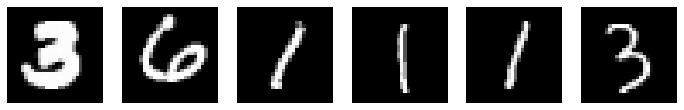

In [55]:
import png

num_examples = 6
# offset = 100
offset = 200

plt.figure(figsize=(num_examples*2, 2))
for i in range(num_examples):
    plt.subplot(1, num_examples, i+1)
    plt.axis('off')
    # example = np.squeeze(np.array(x_test[offset+i]*255).astype("uint8"))
    example = np.squeeze(np.array(x_test[offset+i]).astype("uint8"))
    plt.imshow(example, cmap="gray")
    w = png.Writer(28, 28, greyscale=True)
    w.write(open("mnist_example_{}.png".format(i+1), 'wb'), example)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Input, Dropout

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

## Define the model

The model definition in Keras can be done using the `Sequential` or the functional API. Shown here is the `Sequential` API allowing to stack neural network layers on top of each other, which is feasible for most neural network models. In contrast, the functional API would allow to have multiple inputs and outputs for a maximum of flexibility to build your custom model.

In [50]:
# conv layer with 8 3x3 filters

model = Sequential(
    [
        Input(shape=input_shape),
        Conv2D(8, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(16, activation="relu"),
        Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1352)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                21648     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                170       
Total params: 21,898
Trainable params: 21,898
Non-trainable params: 0
_________________________________________________________________


## Compile the model

Using Keras, you have to `compile` a model, which means adding the loss function, the optimizer algorithm and validation metrics to your training setup.

In [51]:
model.compile(loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"])

## Train the model

The cell below shows the training procedure of Keras using the `model.fit(...)` method. Besides typical options such as `batch_size` and `epochs`, which control the number of gradient steps of your training, Keras allows to use callbacks during training.

Callbacks are methods, which are called during training to perform tasks such as saving checkpoints of the model (`ModelCheckpoint`) or stop the training early if a convergence criteria is met (`EarlyStopping`).

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
            filepath="mnist_keras_model.h5",
            save_best_only=True,
            verbose=1)
early_stopping = EarlyStopping(patience=2)

history = model.fit(x_train, y_train, # Training data
            batch_size=200, # Batch size
            epochs=50, # Maximum number of training epochs
            validation_split=0.5, # Use 50% of the train dataset for validation
            callbacks=[checkpoint, early_stopping]) # Register callbacks

Epoch 1/50
150/150 [==============================] - 9s 53ms/step - loss: 2.2998 - accuracy: 0.3898 - val_loss: 1.1782 - val_accuracy: 0.6398

Epoch 00001: val_loss improved from inf to 1.17819, saving model to mnist_keras_model.h5
Epoch 2/50
150/150 [==============================] - 6s 43ms/step - loss: 0.7431 - accuracy: 0.8025 - val_loss: 0.4158 - val_accuracy: 0.9048

Epoch 00002: val_loss improved from 1.17819 to 0.41576, saving model to mnist_keras_model.h5
Epoch 3/50
150/150 [==============================] - 6s 42ms/step - loss: 0.3036 - accuracy: 0.9223 - val_loss: 0.3020 - val_accuracy: 0.9305

Epoch 00003: val_loss improved from 0.41576 to 0.30205, saving model to mnist_keras_model.h5
Epoch 4/50
150/150 [==============================] - 6s 42ms/step - loss: 0.2075 - accuracy: 0.9454 - val_loss: 0.2443 - val_accuracy: 0.9420

Epoch 00004: val_loss improved from 0.30205 to 0.24435, saving model to mnist_keras_model.h5
Epoch 5/50
150/150 [==============================] - 6s

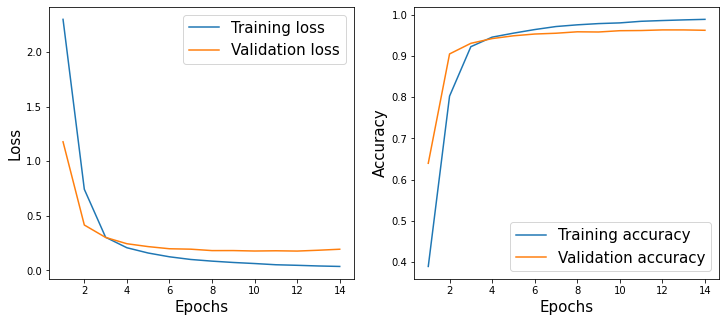

In [53]:
epochs = range(1, len(history.history["loss"])+1)
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["loss"], label="Training loss")
plt.plot(epochs, history.history["val_loss"], label="Validation loss")
plt.legend(fontsize=15), plt.xlabel("Epochs", fontsize=15), plt.ylabel("Loss", fontsize=15)
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["accuracy"], label="Training accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation accuracy")
plt.legend(fontsize=15), plt.xlabel("Epochs", fontsize=15), plt.ylabel("Accuracy", fontsize=15);

## Test the model

The prediction of unseen data is performed using the `model.predict(inputs)` call. Below, a basic test of the model is done by calculating the accuracy on the test dataset.

In [54]:
# Get predictions on test dataset
y_pred = model.predict(x_test)

# Compare predictions with ground truth
test_accuracy = np.sum(
        np.argmax(y_test, axis=1)==np.argmax(y_pred, axis=1))/float(x_test.shape[0])

print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.9676
